In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
from scipy import stats

### 데이터 읽어오기

In [16]:
df = pd.read_excel("dataset.xlsx")

### 1. 수면 종합점수 sleep_score와 연관성이 가장 높은 항목 두 개를 추출하고, sleep_score를 설명하는 중요한 요인을 파악.

In [17]:
#sleep 관련 변수 필터링
sleep_cols = [col for col in df.columns if 'sleep' in col.lower()]
sleep_cols.remove('sleep_score_total')

sleep_data = df[sleep_cols]

#sleep 관련 각각 col들과 'sleep_score'와의 pearson correlation 구하기
corr_score_for_each_var = sleep_data.corr(method='pearson', numeric_only=True)['sleep_score']

#pearson correlation이 가장 높은 두 개의 col 구하기
top2_highest_corr = corr_score_for_each_var.drop('sleep_score').abs().nlargest(2)
var1 = top2_highest_corr.index[0]
var2 = top2_highest_corr.index[1]

#방금 구한 두 개의 col과 sleep_score와의 pearson correlation의 신뢰성 검정하기
data_clean = df.dropna(axis=0, how='any', inplace=False)

for x in top2_highest_corr.index:
    var, pvalue_var = pearsonr(data_clean[x], data_clean['sleep_score'])
    print(f'{x}의 pearson correlation은 {round(var, 4)}이고, p-value는 {round(pvalue_var, 4)}입니다.')
    if (pvalue_var < 0.05):
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있습니다.')
    else:
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있다고 볼 수 없습니다.')
    print('\n')

sleep_total의 pearson correlation은 0.7597이고, p-value는 0.0입니다.
sleep_total은 sleep_score와 유의미하게 상관성이 있습니다.


sleep_efficiency의 pearson correlation은 0.6259이고, p-value는 0.0입니다.
sleep_efficiency은 sleep_score와 유의미하게 상관성이 있습니다.




### 1.2 sleep_cols들과 sleep_score의 상관성을 시각화: png로 저장

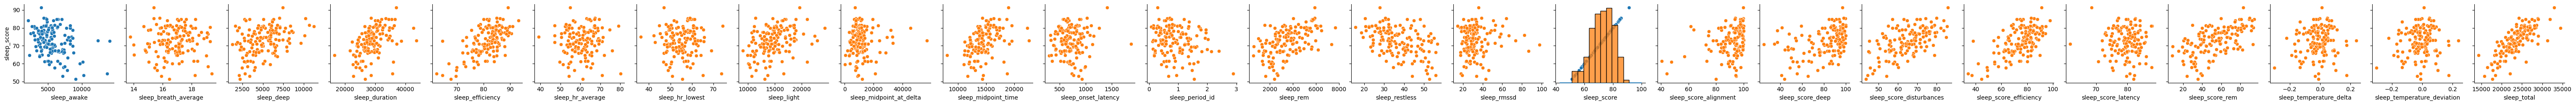

In [18]:
#sleep_cols들과 sleep_score의 상관성을 scatter plot으로 그린 결과
g = sns.pairplot(data=sleep_data, x_vars= sleep_cols, y_vars= ['sleep_score'], kind='scatter',diag_kind='kde', dropna=True)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

plt.savefig('sleep_cols_and_sleep_score.png')

### 2. ANOVA: CN, MCI, Dem 그룹의 수면점수가 차이나는 지 검사
* H0: CN, MCI, Dem의 평균 수면 점수는 서로 동일하다 (치매 단계 간 수면 점수의 평균에 차이가 없다.)
* H1: CN, MCI, Dem 세 그룹 중 적어도 하나의 그룹의 수면 점수가 다른 그룹과 차이가 있다.
* alpha = 0.05

### ANOVA TABLE

In [19]:
df.groupby('DIAG_NM').agg({'sleep_score': ['mean', 'std', 'min', 'max']})

sleep_score_fit = smf.ols("sleep_score~C(DIAG_NM, Sum)", data = df).fit()
table = sm.stats.anova_lm(sleep_score_fit)
print(table)

alpha = 0.05
p_value = table['PR(>F)'].iloc[0]
if (p_value > alpha):
    print("\nH0를 기각하지 않습니다.\n수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.")
else:
    print("\nH0를 기각합니다.\n수면시간은 각 진단명에 따라 차이가 있습니다.")



                    df       sum_sq    mean_sq         F   PR(>F)
C(DIAG_NM, Sum)    2.0    12.258319   6.129159  0.100025  0.90488
Residual         138.0  8456.087091  61.275993       NaN      NaN

H0를 기각하지 않습니다.
수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.


### Mulicomparison table

In [20]:
comp = mc.MultiComparison(df['sleep_score'], df['DIAG_NM'])
compatible,_,_ = comp.allpairtest(stats.ttest_ind, method = 'bonf')
compatible

group1,group2,stat,pval,pval_corr,reject
CN,Dem,0.1967,0.8445,1.0,False
CN,MCI,0.4372,0.6627,1.0,False
Dem,MCI,0.0187,0.9851,1.0,False
